In [1]:
from google.colab import files
files.upload()

!unzip -q bank-full.zip
!pip install --upgrade seaborn

Saving bank-full.zip to bank-full.zip
Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
import xgboost as xgb


In [3]:
df_bank = pd.read_csv('/content/bank-full.csv',header = None)
df_bank = df_bank[0].str.split(";",expand=True).applymap(lambda x: x.replace('"', ''))
df_bank.columns = ['customer_age', 'job_type', 'marital', 'education', 'default', 'balance', 'housing_loan', 'personal_loan', 'communication_type', 'day_of_month', 'month',
                   'last_contact_duration','num_contacts_in_campaign','days_since_prev_campaign_contact','num_contacts_prev_campaign','prev_campaign_outcome','term_deposit_subscribed']
df_bank = df_bank[1:]

## Attribute information:

1.  customer_age (numeric)
2.  job_type : type of job (categorical)
3.  marital : marital status (categorical; note: "divorced" means divorced or widowed)
4.  education (categorical: "unknown","secondary","primary","tertiary")
5.  default: has credit in default? (binary)
6.  balance: average yearly balance, in euros (numeric)
7.  housing_loan: has housing loan? (binary)
8.  personal_loan: has personal loan? (binary)
###Related with the last contact of the current campaign:
9.  communication_type: contact communication type (categorical)
10. day_of_month: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. last_contact_information: last contact duration, in seconds (numeric)
###Other attributes:
13. num_contacts_in_campaign: number of contacts performed during this campaign and for this client (numeric, includes
last contact)
14. days_since_prev_campaign_contact: number of days that passed by after the client was last contacted from a previous campaign
(numeric, -1 means client was not previously contacted)
15. num_contacts_prev_campaign: number of contacts performed before this campaign and for this client (numeric)
16. prev_campaign_outcome: outcome of the previous marketing campaign (categorical)
Output variable (desired target):
17. term_deposit_subscribed - has the client subscribed a term deposit? (binary: "yes","no")

In [4]:
df_bank.head(15)

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
6,35,mgmt,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
7,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
8,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
9,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
10,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


#### Hypothesis Generation

* Are younger customers more likely to subscribe to a term deposit as compared to old customers ?

* Are people with a higher bank balance more likely subscribe to term deposit than people with low balance ?

* Does a married person have higher chances to subscribe to a term deposit compared to a single or divorced person ? 

* Does the length of the call made to the customers tell us anything about their chances of subscribing ?
(One may think that if the call length is longer, the customer executive has spent a longer time, discussing details with customer, hence the customer is more likely to subscribe).

In [5]:
print("###################################################################")
print(df_bank.columns)
print("###################################################################")
print(df_bank.isnull().sum())
print("###################################################################")
print(df_bank.info())

###################################################################
Index(['customer_age', 'job_type', 'marital', 'education', 'default',
       'balance', 'housing_loan', 'personal_loan', 'communication_type',
       'day_of_month', 'month', 'last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign', 'prev_campaign_outcome',
       'term_deposit_subscribed'],
      dtype='object')
###################################################################
customer_age                        0
job_type                            0
marital                             0
education                           0
default                             0
balance                             0
housing_loan                        0
personal_loan                       0
communication_type                  0
day_of_month                        0
month                               0
last_contact_duration               0
num_contacts_in_ca

In [6]:
# Convert integer type features in its appropriate format
num_cols = ['customer_age',
            'balance',
            'day_of_month',
            'last_contact_duration',
            'num_contacts_in_campaign',
            'days_since_prev_campaign_contact',
            'num_contacts_prev_campaign']
cat_cols = [col for col in df_bank.columns if col not in num_cols]
print('Categorical Columns:',cat_cols)
print('Numerical Columns:',num_cols)

Categorical Columns: ['job_type', 'marital', 'education', 'default', 'housing_loan', 'personal_loan', 'communication_type', 'month', 'prev_campaign_outcome', 'term_deposit_subscribed']
Numerical Columns: ['customer_age', 'balance', 'day_of_month', 'last_contact_duration', 'num_contacts_in_campaign', 'days_since_prev_campaign_contact', 'num_contacts_prev_campaign']


In [7]:
# Converting numercial type columns data in their respective format
df_bank[num_cols] = df_bank[num_cols].astype('int64')
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 1 to 45211
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   customer_age                      45211 non-null  int64 
 1   job_type                          45211 non-null  object
 2   marital                           45211 non-null  object
 3   education                         45211 non-null  object
 4   default                           45211 non-null  object
 5   balance                           45211 non-null  int64 
 6   housing_loan                      45211 non-null  object
 7   personal_loan                     45211 non-null  object
 8   communication_type                45211 non-null  object
 9   day_of_month                      45211 non-null  int64 
 10  month                             45211 non-null  object
 11  last_contact_duration             45211 non-null  int64 
 12  num_contacts_in_ca

In [8]:
df_bank.describe()

,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
# There might be some features which are having same categorical value but are represent in different form
# Lets iterate all the categorical columns and check their values
for col in cat_cols:
  print("Unique values in {0} are - {1}".format(col,df_bank[col].unique()))

Unique values in job_type are - ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown' 'mgmt'
 'retired' 'admin' 'admin.' 'services' 'self-employed' 'unemployed'
 'housemaid' 'student']
Unique values in marital are - ['married' 'single' 'divorced']
Unique values in education are - ['tertiary' 'secondary' 'unknown' 'primary']
Unique values in default are - ['no' 'yes']
Unique values in housing_loan are - ['yes' 'no']
Unique values in personal_loan are - ['no' 'yes']
Unique values in communication_type are - ['unknown' 'cellular' 'telephone']
Unique values in month are - ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Unique values in prev_campaign_outcome are - ['unknown' 'failure' 'other' 'success']
Unique values in term_deposit_subscribed are - ['no' 'yes']


In [10]:
# admin and admin. in job feature are same
df_bank['job_type'].replace('admin.','admin', inplace=True)
# admin and admin. in job feature are same
df_bank['job_type'].replace('mgmt','management', inplace=True)

# Check all the values in Job type
df_bank['job_type'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [11]:
# after looking at the dataset 'days_since_prev_campaign_contact' is having most of the data values as -1
df_bank['days_since_prev_campaign_contact'].value_counts()

-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 717        1
 589        1
 493        1
 32         1
Name: days_since_prev_campaign_contact, Length: 559, dtype: int64

It implies that a lot of customers where not been contacted in the last compaign.

In [12]:
# Lets replace -1 to 0 as it will impact tha mean and will have no impact once multiplied with coefficients
df_bank['days_since_prev_campaign_contact'].replace(-1,0, inplace=True)

### Categorical Features

#### Univariate Analysis - Pie Charts.
Lets check the proportion of the samples

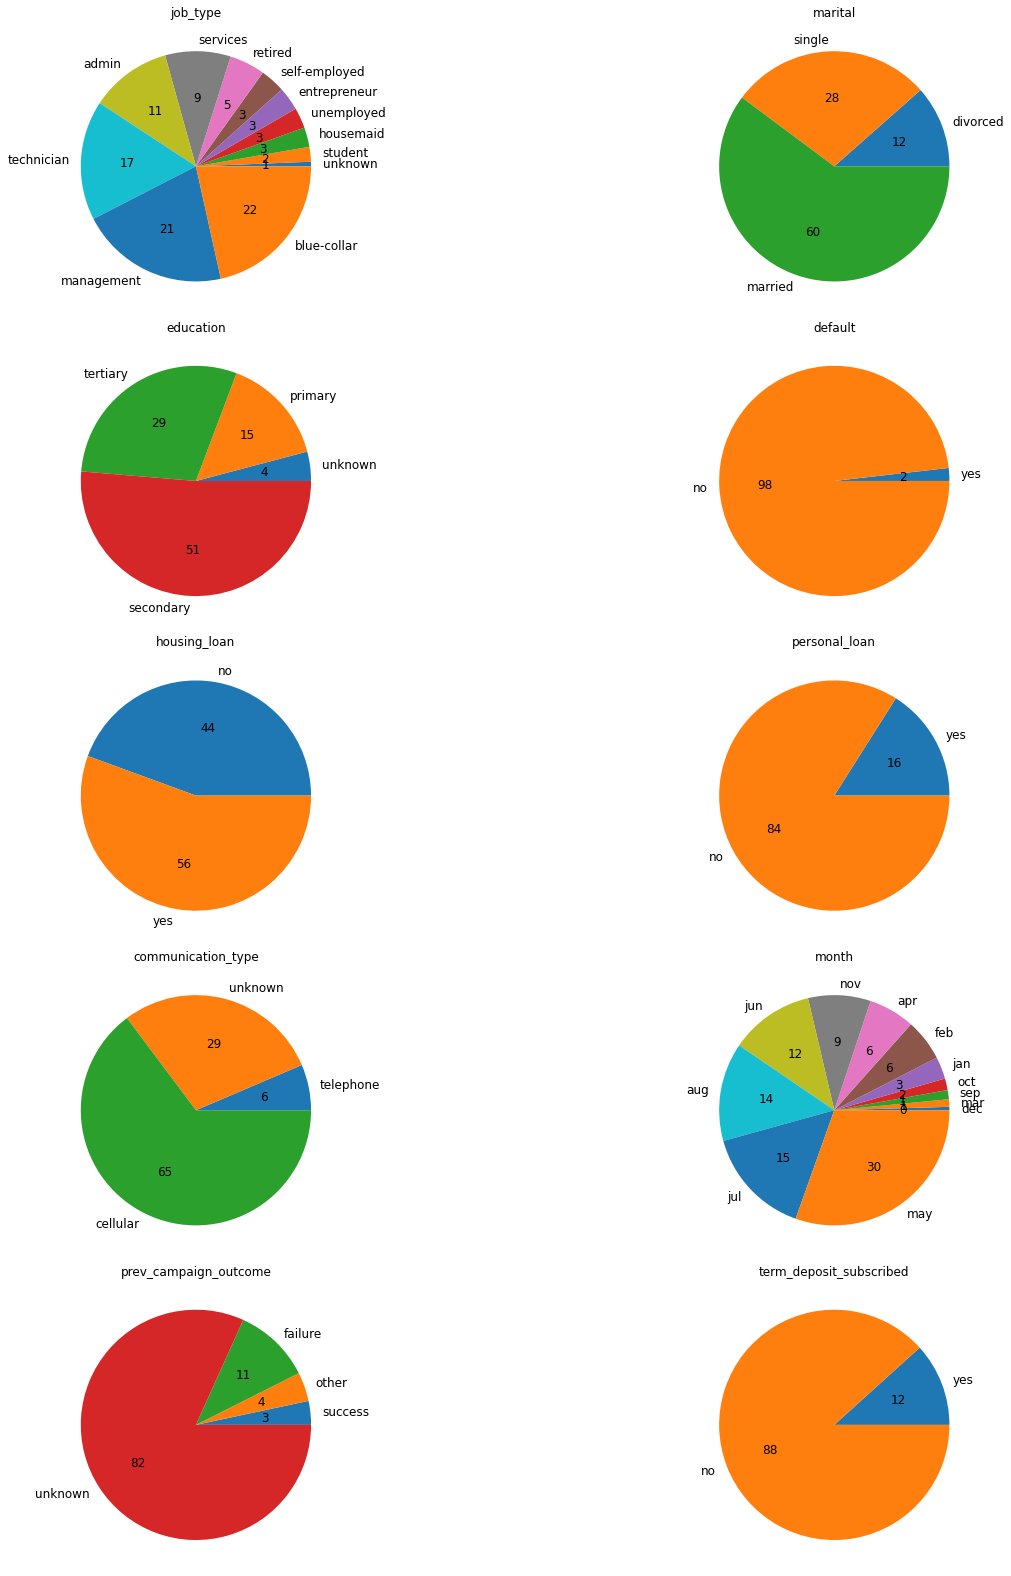

In [13]:
fig, axes = plt.subplots(5,2, figsize = (22,22))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(cat_cols):
  df_bank[c].value_counts()[::-1].plot(kind='pie',ax=axes[i],title=c,autopct='%.0f',fontsize=12)
  axes[i].set_ylabel('')
plt.tight_layout()

#### Univariate Analysis - CountPlots
Looking at the counts of each of the categories is countplots.

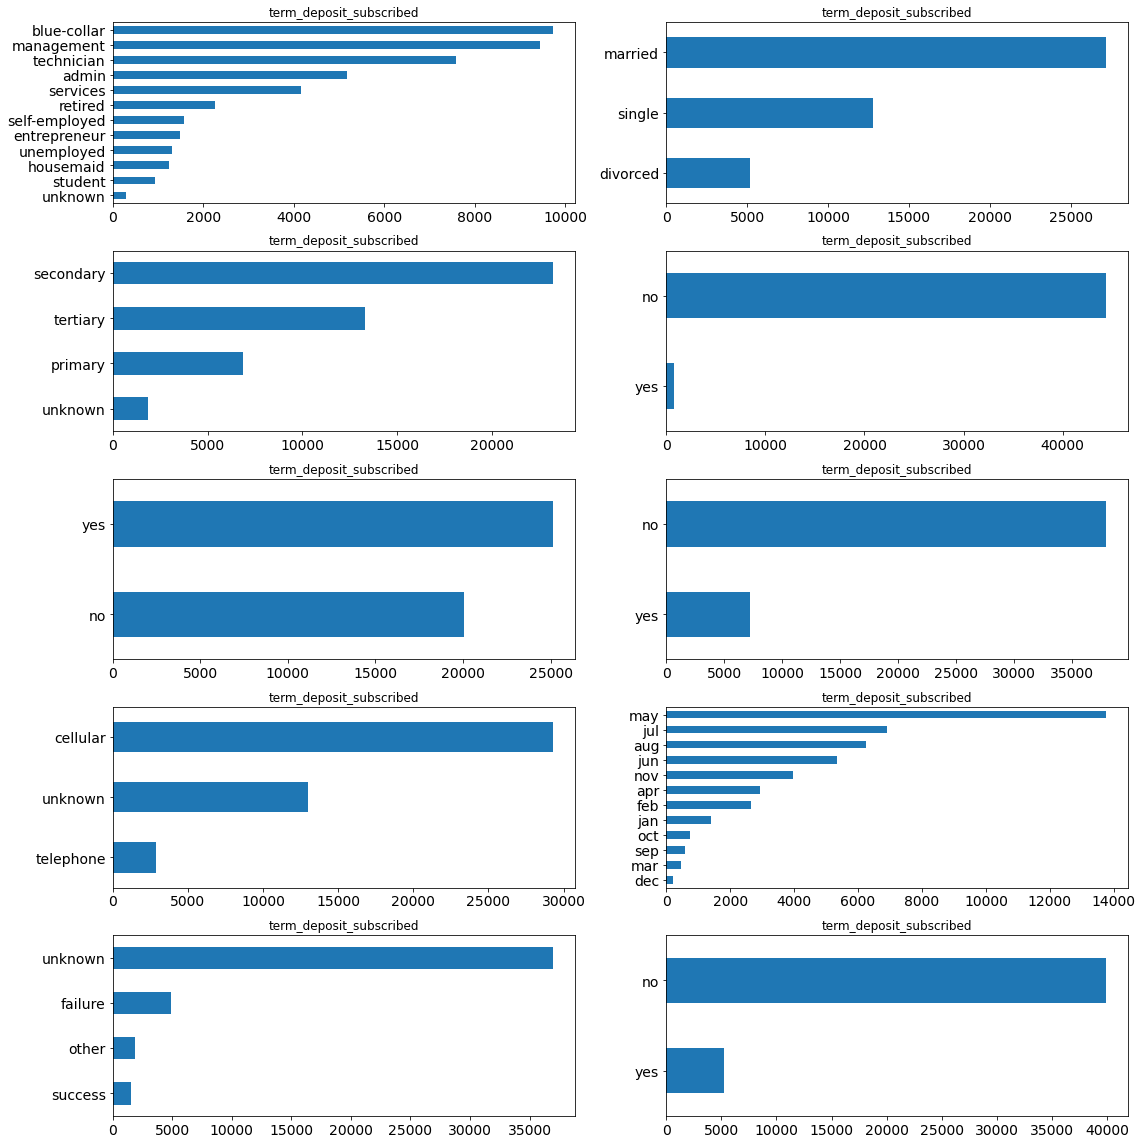

In [14]:
fig, axes = plt.subplots(5,2,figsize=(16,16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, col  in enumerate(cat_cols):
  df_bank[col].value_counts()[::-1].plot(kind='barh',ax=axes[i], title=c, fontsize=14)

plt.tight_layout()

###Bivariate Analysis Relationships with Target

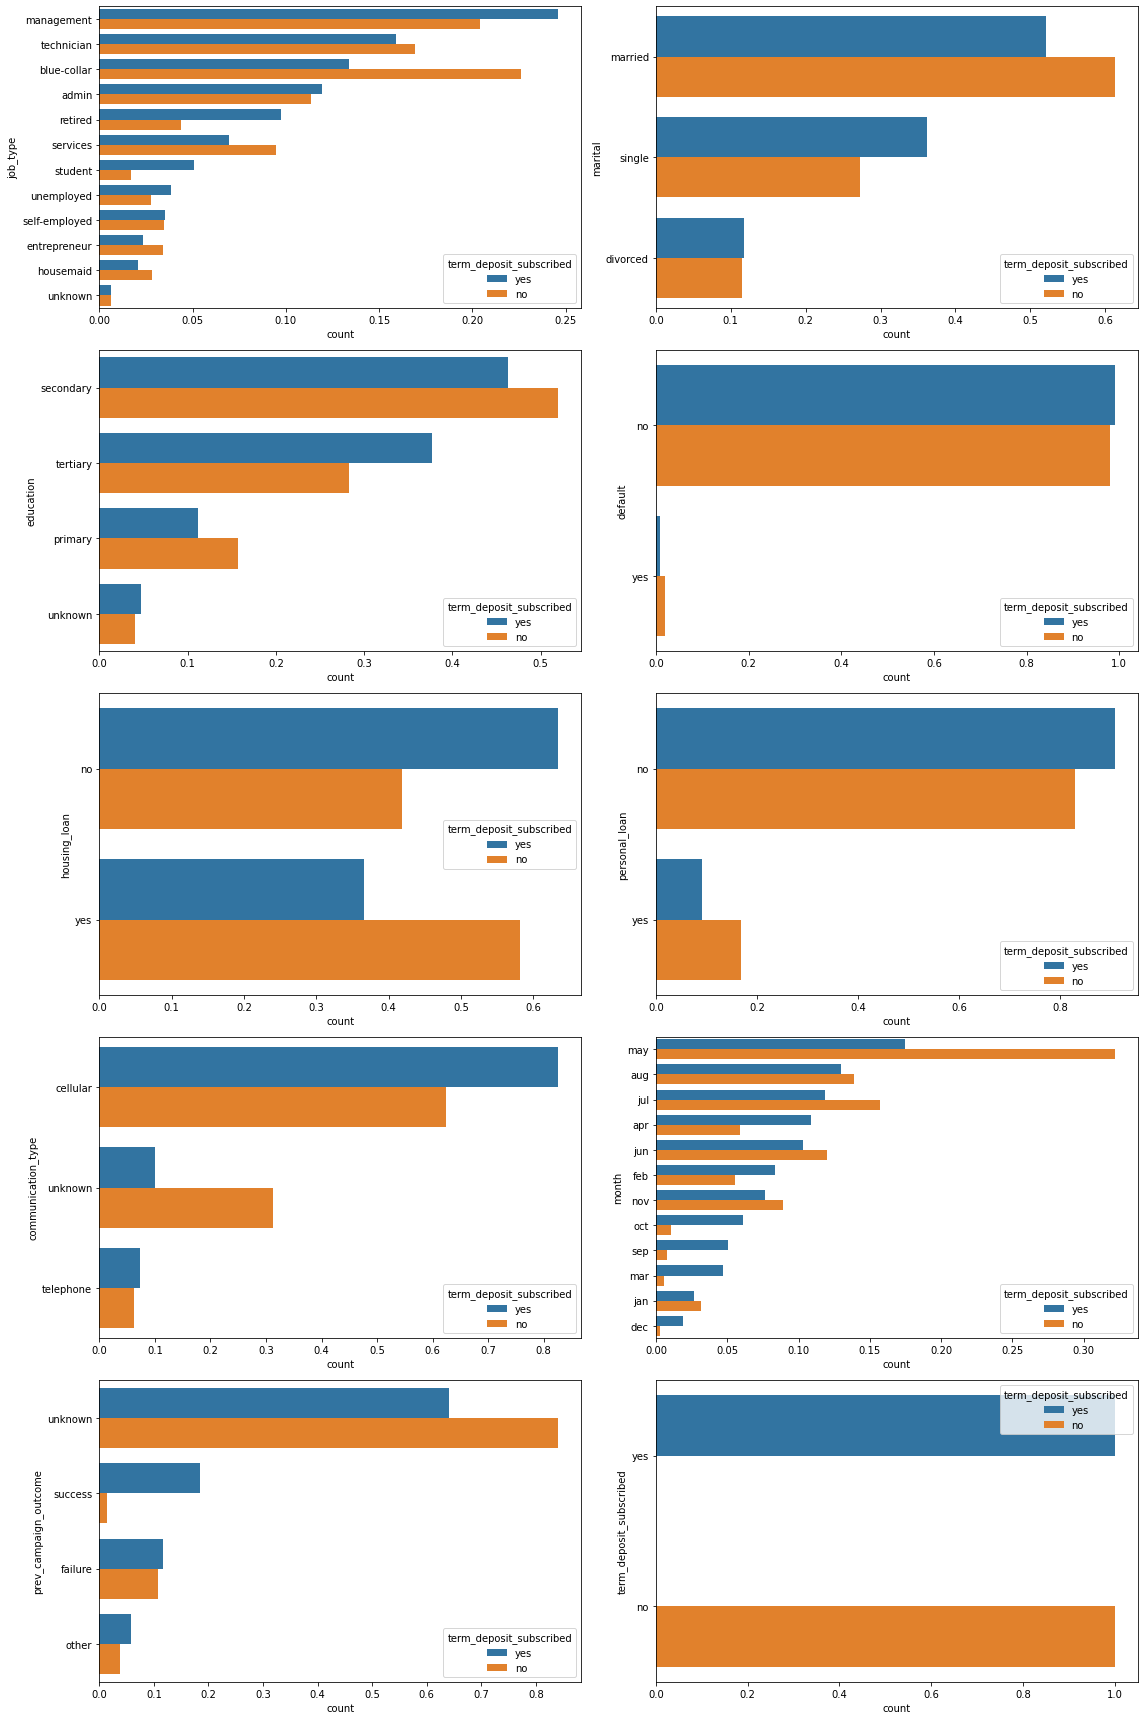

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

TARGET_COL = 'term_deposit_subscribed'
for i, c in enumerate(cat_cols):
  fltr = df_bank[TARGET_COL]=='yes'
  vc_a = df_bank[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

  vc_b = df_bank[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

  vc_a[TARGET_COL] = 'yes'
  vc_b[TARGET_COL] = 'no'

  dataset = pd.concat([vc_a, vc_b]).reset_index(drop = True)

  sns.barplot(y = c, x = 'count', data =dataset , hue=TARGET_COL, ax=axes[i])
    
plt.tight_layout()

In [16]:
# For getting the mean we need to have y column as int type. So lets convert the y(target column) as numerical form
df_bank[[TARGET_COL]] = df_bank[[TARGET_COL]].apply(lambda x: pd.factorize(x)[0])
df_bank[[TARGET_COL]].tail()

,term_deposit_subscribed
45207,1
45208,1
45209,1
45210,0
45211,0


**Q. Do married people have more chances of subscribing to a term deposit ?**

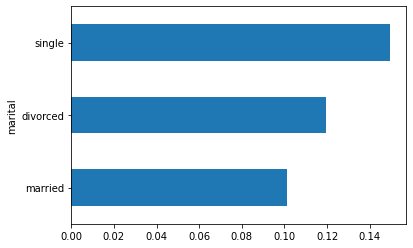

In [17]:
df_bank.groupby('marital')[TARGET_COL].mean().sort_values().plot(kind = 'barh')

The data tells us quite a different story than our initial thought process, single people are the more likely to subscribe to a term deposit. 

#### Numerical Features

##### 1. Univariate Analysis - Boxplots

Boxplot can be used to see the spread of the numerical variables, and identify outliers

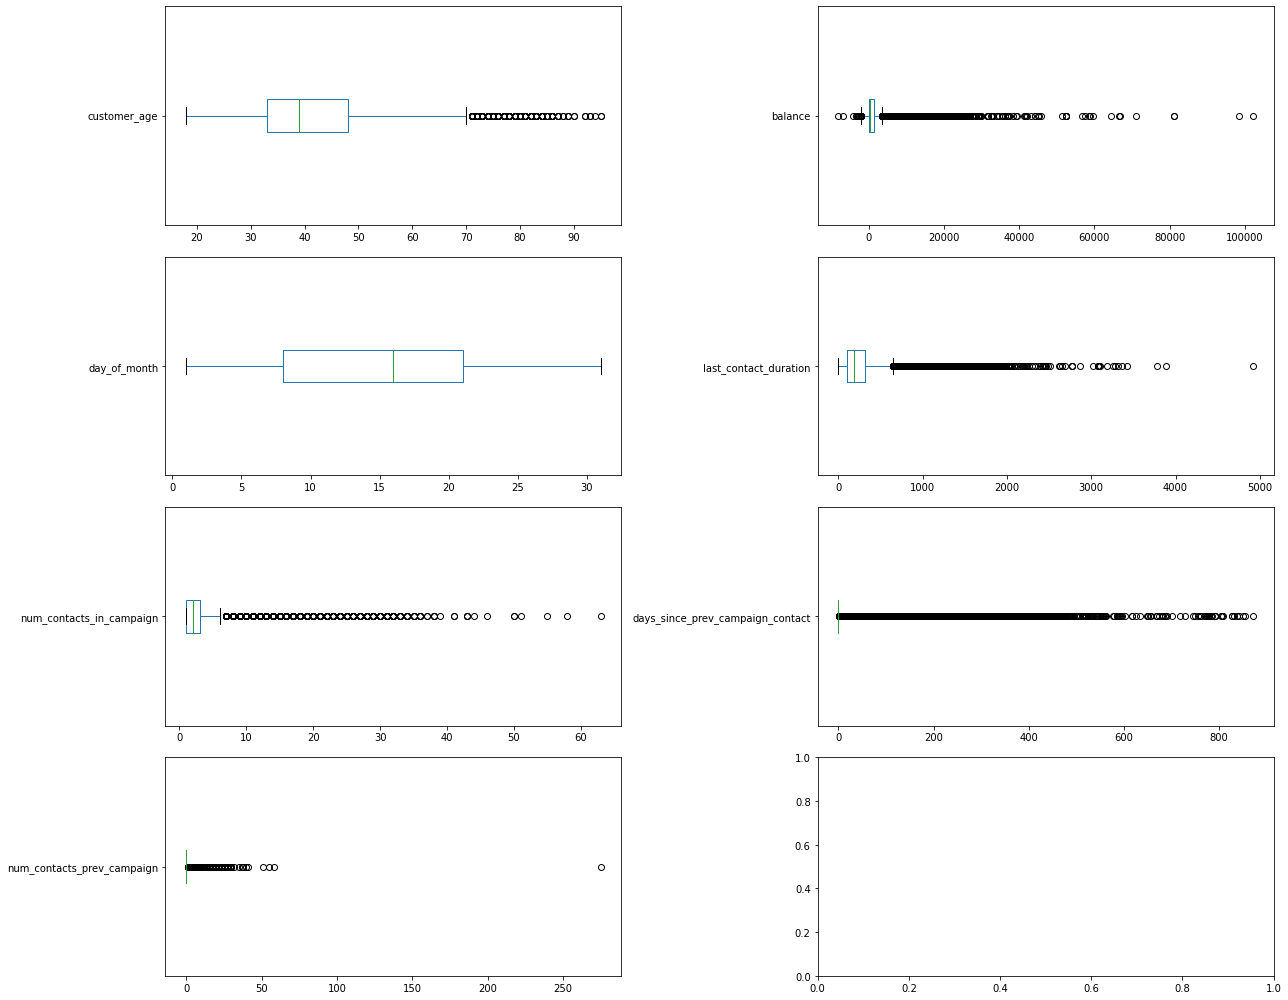

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]

for i, col in enumerate(num_cols):
  df_bank[col].plot(kind='box', ax=axes[i],vert=False)

plt.tight_layout()

##### 2. Univariate Analysis - Density Plots
visualizing the distribution of observations in a dataset

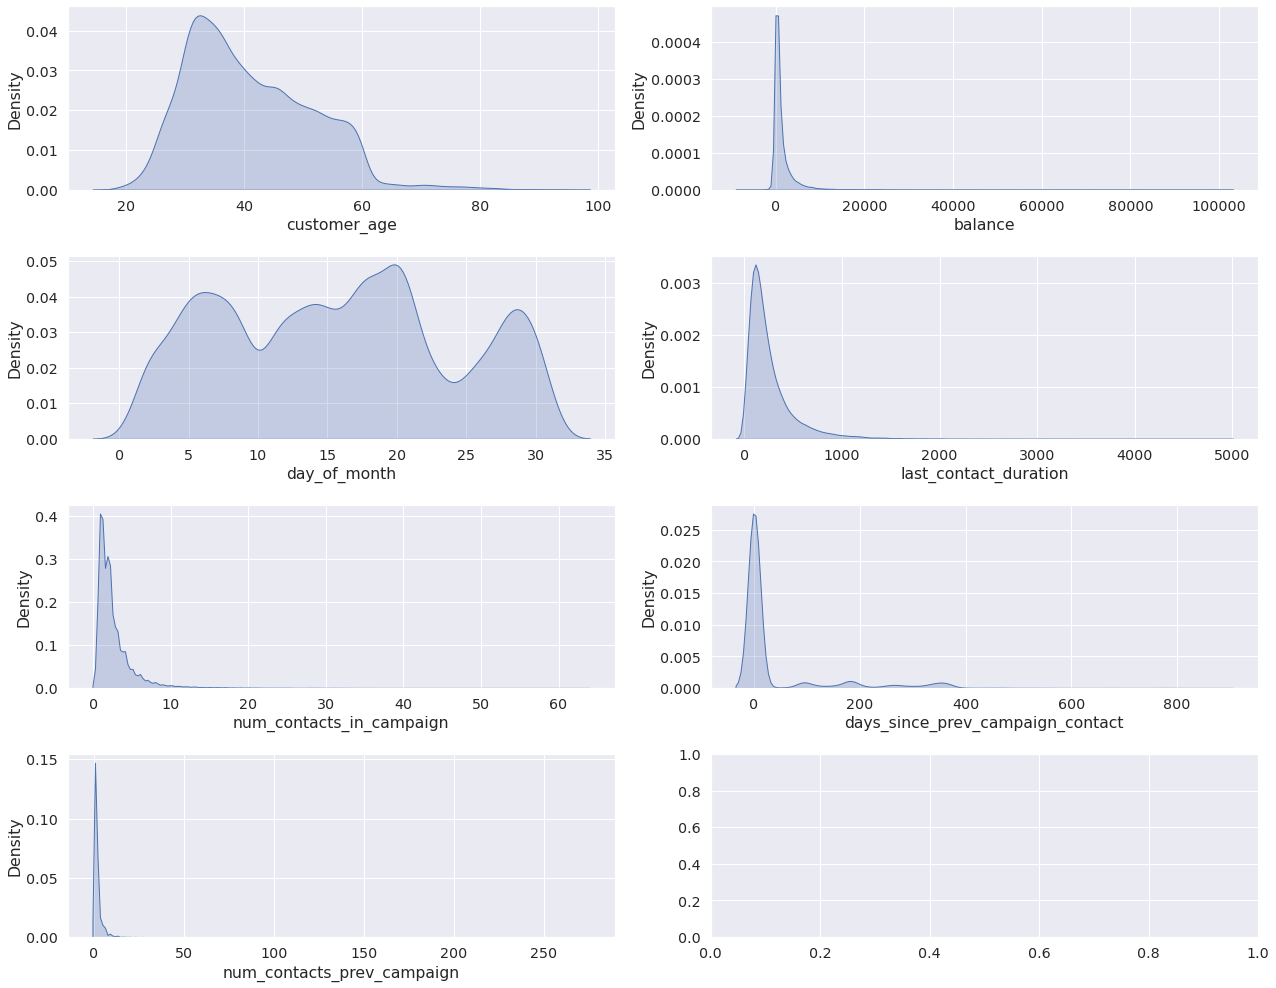

In [19]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=df_bank, x=c, ax=axes[i], fill=True)
plt.tight_layout()

##### 3. Bivariate Analysis KDE plots - Relationships with Target Variable.

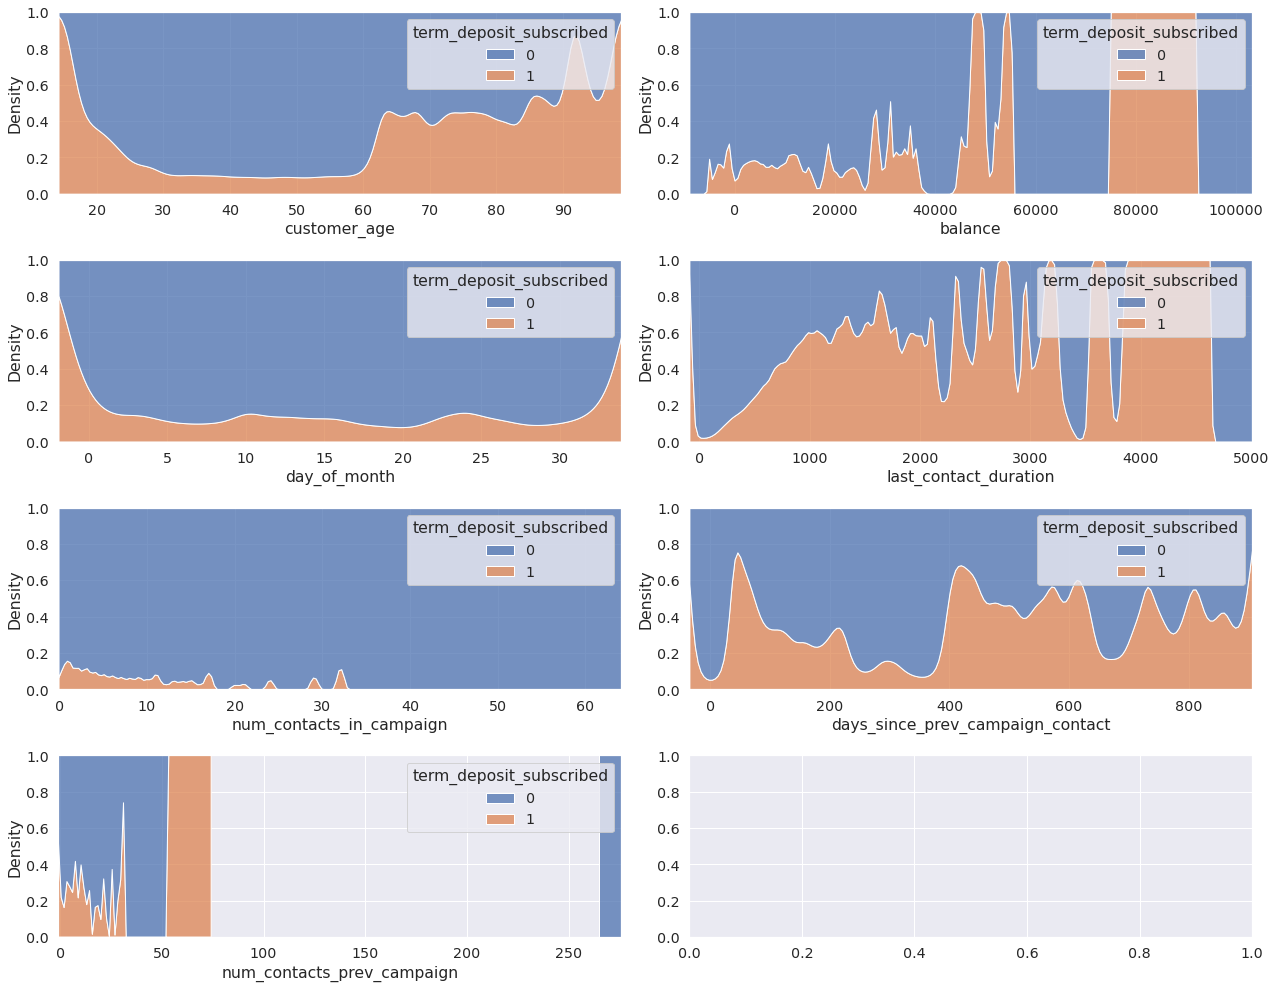

In [20]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=df_bank, x=c, hue=TARGET_COL, multiple='fill', ax=axes[i])
plt.tight_layout()

##### 4. Bivariate Analysis - Horizontal BarPlots

For each numerical Variable. We will plot the median of the numerical variable for:


1. When 1 == 'yes'
2. when 0 == 'no'

**Choosing median since median is not affected by outliers**, and our data has a lot of outlers

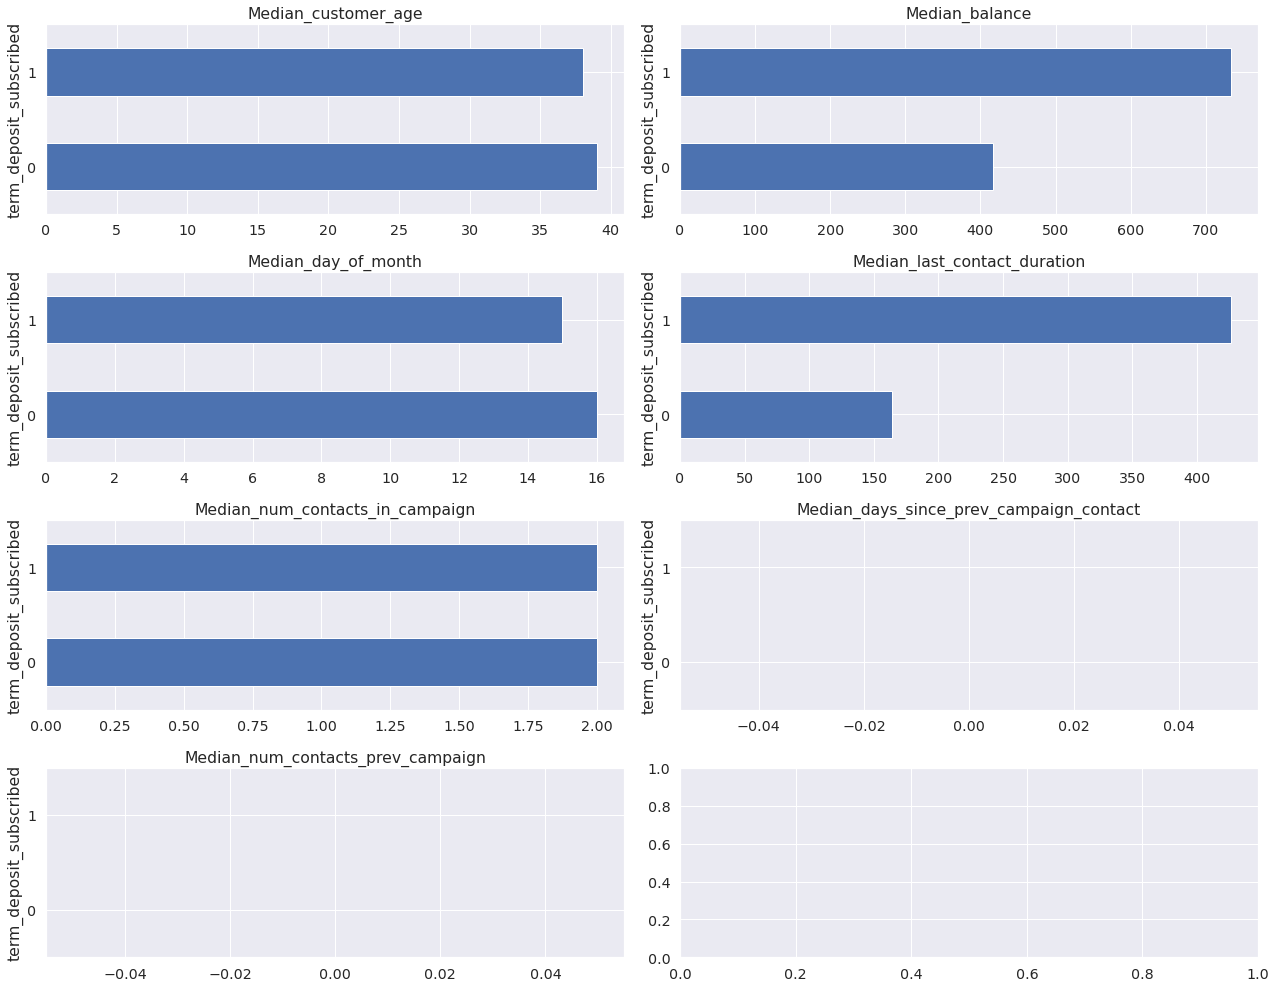

In [21]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4,2,figsize = (18,14))
axes = [ax for axes_row in axes for ax in axes_row]

for i, col in enumerate(num_cols):
  plot = df_bank.groupby(TARGET_COL)[col].median().plot(kind = 'barh', title=f'Median_{col}', ax=axes[i])
plt.tight_layout()

**Q. Do people with a higher bank balance more likely subscribe to term deposit than people with low balance ?**

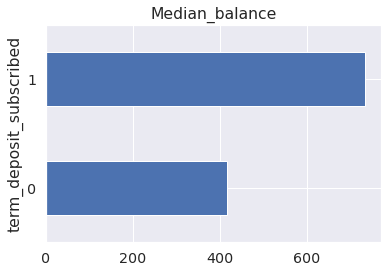

In [22]:
df_bank.groupby(TARGET_COL)['balance'].median().plot(kind = 'barh', title=f'Median_balance')

If you see the plot above median balance of customers not subscribing to a term deposit is around 400 whereas median balance of customers subscribing to a term deposit is 800. This definitely supports our initial hypothesis.

**Q. Does the length of the call made to the customers tell us anything about their chances of subscribing ?**

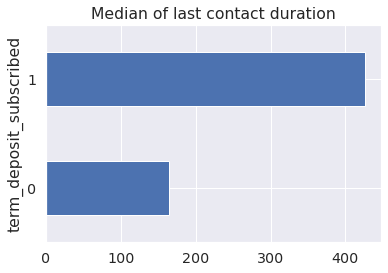

In [23]:
df_bank.groupby(TARGET_COL)['last_contact_duration'].median().plot(kind = 'barh', title=f'Median of last contact duration')

From the plot above median duration made to the customers not subscribing to a term deposit is around 150 seconds. Median of last call duration made to the customers subscribing to a term deposit is around 450 seconds. So yes our hypothesis seems true.

**Q. Are younger customers more likely to subscribe to a term deposit compared to old customers ?**

It's not very clear from our above plot since we have median age of around 40 for both cases

Lets dig deeper.

We will define:
 old as Age > 60
 Not Old as Age <= 60

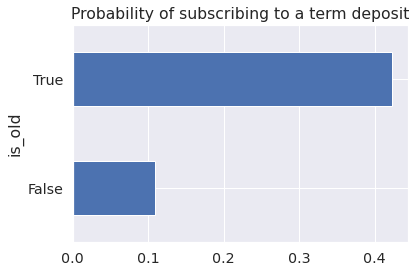

In [24]:
df_bank['is_old'] = True
df_bank.loc[df_bank['customer_age'] <= 60, 'is_old'] = False

df_bank.groupby('is_old')[TARGET_COL].mean().sort_values().plot(kind = 'barh', title='Probability of subscribing to a term deposit')

Looks like old age customers are definitely more likely to subscribe to a term deposit compared to younger age customers

##### **Bivariate Analysis - Correlation Heatmaps**

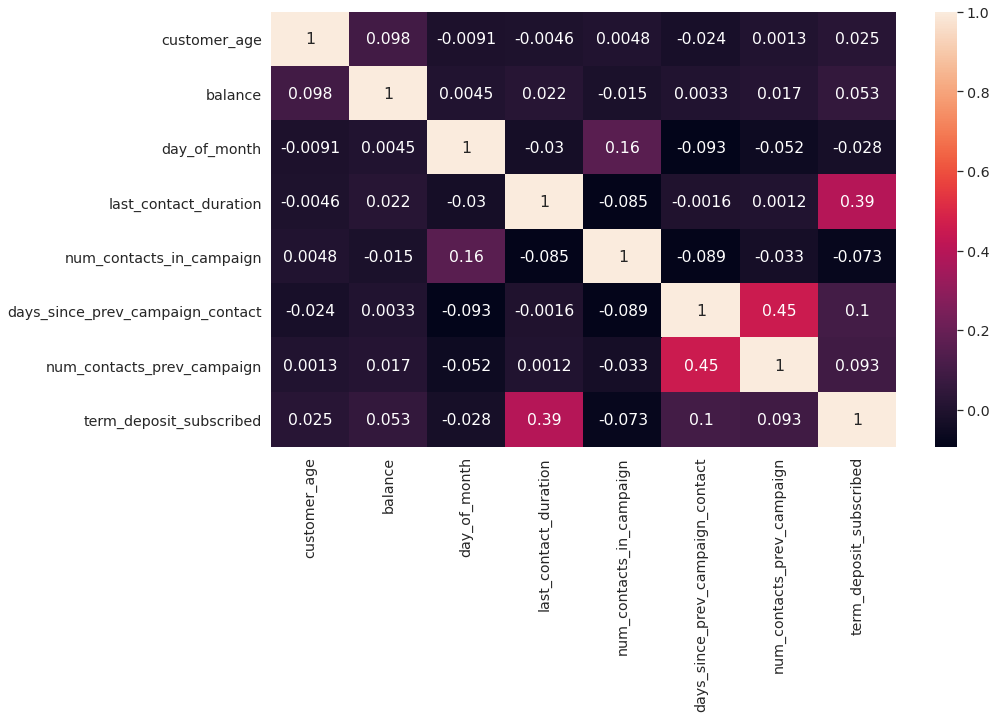

In [25]:
plt.figure(figsize=(14, 8))
num_cols.append(TARGET_COL)
sns.heatmap(df_bank[num_cols].corr(), annot=True)

Here, as per the correlation, most of the features are independent to each other.
There is a weak positive correlation between last contact duration and term deposit subscribed.

#### **Converting categorical data into numerical data**
1. Sparse/One hot encoding
2. Nominal label encoding
3. Ordinal label encoding

In [26]:
# Method 1
cat_col_list = ['default','housing_loan','personal_loan']
pd.get_dummies(df_bank, columns = cat_col_list,drop_first=True)

,customer_age,job_type,marital,education,balance,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed,is_old,default_yes,housing_loan_yes,personal_loan_yes
1,58,management,married,tertiary,2143,unknown,5,may,261,1,0,0,unknown,0,False,0,1,0
2,44,technician,single,secondary,29,unknown,5,may,151,1,0,0,unknown,0,False,0,1,0
3,33,entrepreneur,married,secondary,2,unknown,5,may,76,1,0,0,unknown,0,False,0,1,1
4,47,blue-collar,married,unknown,1506,unknown,5,may,92,1,0,0,unknown,0,False,0,1,0
5,33,unknown,single,unknown,1,unknown,5,may,198,1,0,0,unknown,0,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45207,51,technician,married,tertiary,825,cellular,17,nov,977,3,0,0,unknown,1,False,0,0,0
45208,71,retired,divorced,primary,1729,cellular,17,nov,456,2,0,0,unknown,1,True,0,0,0
45209,72,retired,married,secondary,5715,cellular,17,nov,1127,5,184,3,success,1,True,0,0,0
45210,57,blue-collar,married,secondary,668,telephone,17,nov,508,4,0,0,unknown,0,False,0,0,0


In [27]:
# Method 2
cat_col_list = ['job_type','marital','communication_type','month','prev_campaign_outcome']
for i, col in enumerate(cat_col_list):
  df_bank[[col+"_encoded"]] = df_bank[[col]].apply(lambda x: pd.factorize(x)[0])

In [28]:
# Method 3.
label_education_encoding = {'unknown':0,'primary':1,'secondary':2,'tertiary':3}
df_bank['education_encoded'] = df_bank['education'].map(label_education_encoding)

In [29]:
df_bank.columns

Index(['customer_age', 'job_type', 'marital', 'education', 'default',
       'balance', 'housing_loan', 'personal_loan', 'communication_type',
       'day_of_month', 'month', 'last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign', 'prev_campaign_outcome',
       'term_deposit_subscribed', 'is_old', 'job_type_encoded',
       'marital_encoded', 'communication_type_encoded', 'month_encoded',
       'prev_campaign_outcome_encoded', 'education_encoded'],
      dtype='object')

**Split the train set into train and validation sets.**

We will use 80-20 split with 80% of the rows belonging to training data. Stratified Sampling is necessary, since the dataset is highly imbalanced. Stratified sampling ensures that the minority class is distributed proportionally among the two classes.

In [30]:
dataset = df_bank.select_dtypes(include='int64')
features = [c for c in dataset.columns if c not in [TARGET_COL]]

In [31]:
train, test = train_test_split(dataset, test_size=0.2, random_state = 1, stratify = dataset[TARGET_COL])

###### Input to our model will be the features
X_train, X_test = train[features], test[features]

###### Output of our model will be the TARGET_COL
y_train, y_test = train[TARGET_COL], test[TARGET_COL]

In [32]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled_data = scaler.transform(X_train)
X_test_scaled_data = scaler.transform(X_test)

Checking prediction on applying ML models

In [33]:
clf = LogisticRegression(random_state = 1)
_ = clf.fit(X_train_scaled_data, y_train)

preds_val = clf.predict(X_test_scaled_data)

f1_score(y_test, preds_val)

0.3779527559055118

In [34]:
clf = DecisionTreeClassifier(random_state = 1)
_ = clf.fit(X_train, y_train)

preds_val = clf.predict(X_test)

f1_score(y_test, preds_val)

0.45506149479659413

# **Hyperparameter Tuning**

In our decision tree model earlier, we did not change any of the parameters that were input to our model. However hyper-parameters and their values vary from dataset to dataset, and their optimal values have a large impact on the performance of our model.

To perform hyperparameter-tuning we specify a list of hyper-parameters to tune and their possible values.

For example:
```
max_depth: [6, 9, 12, 15]
learning_rate: [0.0001, 0.005, 0.01, 0.05]
```

etc.

In [40]:
hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=50)

search = clf.fit(dataset[features], dataset[TARGET_COL])

search.best_params_

{'class_weight': {0: 1, 1: 4},
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 0.8,
 'max_leaf_nodes': 8,
 'min_samples_split': 30}

In [41]:
optimal_params = search.best_params_
clf = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_train, y_train)

preds_val = clf.predict(X_test)

f1_score(y_test, preds_val)

0.5044722719141324

In [171]:
# Parameter Tuning
model = xgb.XGBClassifier()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)

model = xgb.XGBClassifier(max_depth=50, min_child_weight=1,  n_estimators=200,\
                          n_jobs=-1 , verbose=1,learning_rate=0.16)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
f1_score(y_test,y_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.5min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=6, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


0.5344000000000001

In [35]:
model1= xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=6, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
model1.fit(X_train,y_train)
y_pred=model1.predict(X_test)
f1_score(y_test,y_pred)

0.5402237613212574

In [51]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers

In [166]:
model = tf.keras.Sequential()
model.add(keras.layers.Dense(200, input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dense(500,activation='relu'))
model.add(keras.layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 200)               2800      
_________________________________________________________________
dense_147 (Dense)            (None, 500)               100500    
_________________________________________________________________
dense_148 (Dense)            (None, 500)               250500    
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 501       
Total params: 354,301
Trainable params: 354,301
Non-trainable params: 0
_________________________________________________________________
None


In [167]:
history = model.fit(X_train_scaled_data,y_train,epochs=5, verbose=1)

Epoch 1/5
1131/1131 [==============================] - 3s 2ms/step - loss: 1.2473 - accuracy: 0.8924
Epoch 2/5
1131/1131 [==============================] - 3s 2ms/step - loss: 0.2610 - accuracy: 0.8959
Epoch 3/5
1131/1131 [==============================] - 3s 2ms/step - loss: 0.2554 - accuracy: 0.8969
Epoch 4/5
1131/1131 [==============================] - 3s 2ms/step - loss: 0.2513 - accuracy: 0.8984
Epoch 5/5
1131/1131 [==============================] - 3s 2ms/step - loss: 0.2478 - accuracy: 0.8978


In [168]:
f1_score(y_test,model.predict_classes(X_test_scaled_data))

0.5142276422764227

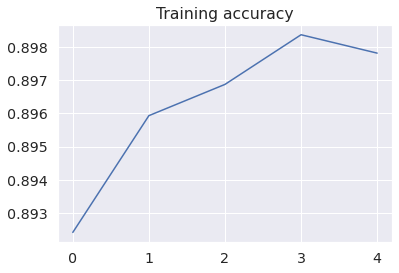

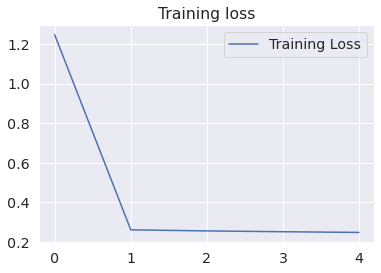

In [169]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [216]:
# for converting the data into pkl and azure pipeline
dataset.to_csv('bankdata.csv',index=False)

In [219]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(model1, 'bank_fd_prediction.pkl') 
  
# Load the model from the file 
xgclassifier = joblib.load('bank_fd_prediction.pkl')  
  
# Use the loaded model to make predictions 
xgclassifier.predict(X_test) 

array([0, 0, 0, ..., 0, 0, 0])

In [221]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(model1) 
  
# Load the pickled model 
knn_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
knn_from_pickle.predict(X_test) 

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
import pickle 
import os
model_file_name = 'bank_fixed_deposit.pkl'
with open(os.path.join('./', model_file_name), 'wb') as file:
    pickle.dump(model1, file)

In [40]:
model = pickle.load(open(model_file_name, "rb"))
cols_when_model_builds = model.get_booster().feature_names
cols_when_model_builds

['customer_age',
 'balance',
 'day_of_month',
 'last_contact_duration',
 'num_contacts_in_campaign',
 'days_since_prev_campaign_contact',
 'num_contacts_prev_campaign',
 'job_type_encoded',
 'marital_encoded',
 'communication_type_encoded',
 'month_encoded',
 'prev_campaign_outcome_encoded',
 'education_encoded']

In [54]:
model.predict(testing).tolist()

[0, 0]